In [1]:
import numpy as np
import pandas as pd

In [2]:
# Generate example data
date_range = pd.date_range(start="2020-01-01", periods=500, freq="d")
data = np.random.normal(50, 8, 500)
df = pd.DataFrame(data, index=date_range, columns=["value"])

# Change the mean starting from 2022-01-21
new_mean = 65
df.loc["2020-08-01":, "value"] = np.random.normal(
    new_mean, 8, len(df.loc["2020-08-01":])
)

In [3]:
df.head()

value
2020-01-01  68.200341
2020-01-02  57.838531
2020-01-03  53.931711
2020-01-04  49.572630
2020-01-05  52.719115

In [4]:
from spyc import SPC, spc_functions, spc_plots

## Basic usage

First, instantate an SPC object. You'll need to provide the dataframe (with DateTime index) and the column name containing the measured process.

You can also specify which subset of the data to calculate and fix the control lines on. If left None, the entire dataset will be used.

In [5]:
basic_example = SPC(data_in=df,
                    target_col="value",
                    fix_control_start_dt=None,
                    fix_control_end_dt=None)

Next, specify the type of SPC chart (using available/ custom functions) and the rules to test. 

There are up to five rules available to test for control (not all are suitable for different SPC types). More information on the rules can be found here:

In [6]:
basic_example_spc_data = basic_example.calculate_spc(
    spc_calc_func=spc_functions.x_chart,  # <- Imported SPC function
    rule_1=True,
    rule_2=True,  
    rule_3=True,  
    rule_4=True,  
    rule_5=True  
)

basic_example_spc_data.head() # Data to create SPC chart

CL        LCL        UCL    process  Rule 1 violation  \
2020-01-01  59.276156  35.790221  82.762091  68.200341                 0   
2020-01-02  59.276156  35.790221  82.762091  57.838531                 0   
2020-01-03  59.276156  35.790221  82.762091  53.931711                 0   
2020-01-04  59.276156  35.790221  82.762091  49.572630                 0   
2020-01-05  59.276156  35.790221  82.762091  52.719115                 0   

            Rule 2 violation  Rule 3 violation  Rule 4 violation  \
2020-01-01                 0                 0                 0   
2020-01-02                 0                 0                 0   
2020-01-03                 0                 0                 0   
2020-01-04                 0                 0                 0   
2020-01-05                 0                 0                 0   

            Rule 5 violation  
2020-01-01                 0  
2020-01-02                 0  
2020-01-03                 0  
2020-01-04                 0  
2020-01-05                 0

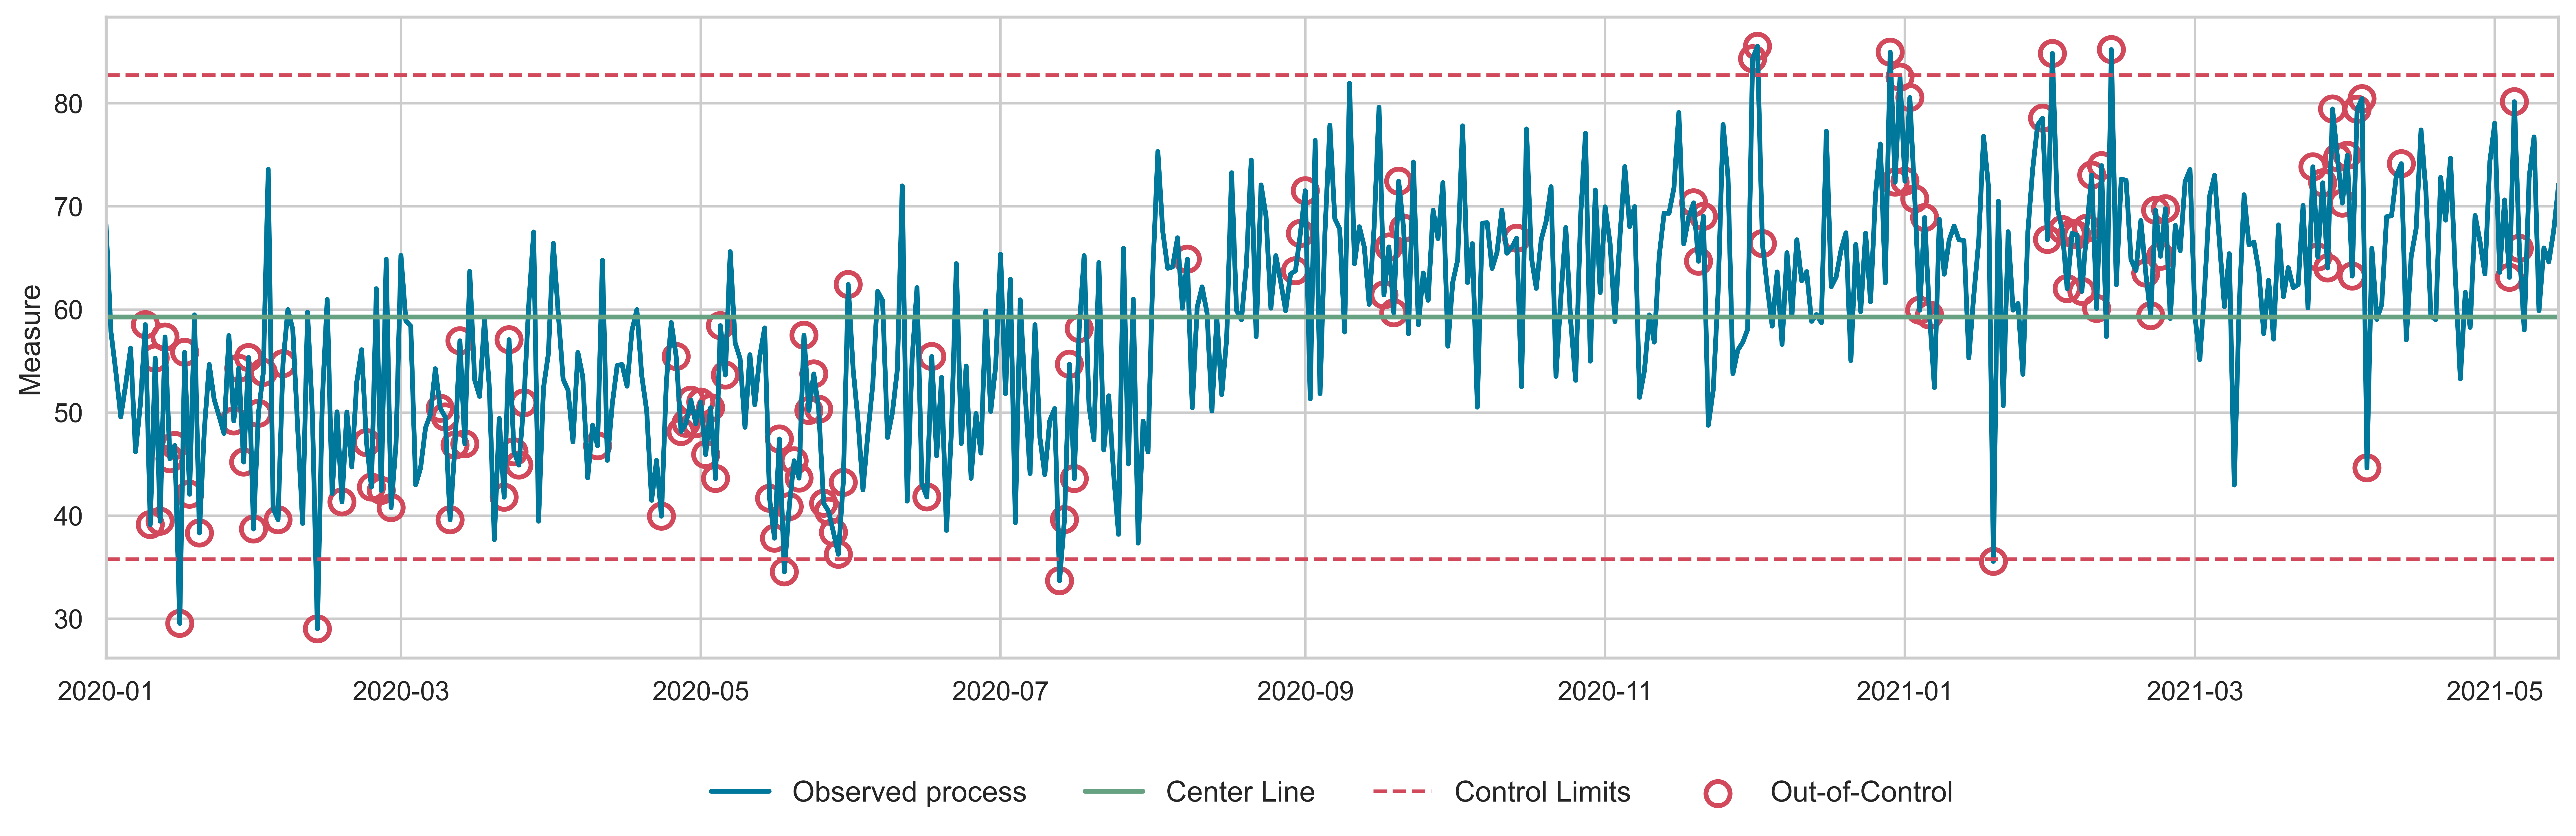

In [7]:
fig, ax = spc_plots.seaborn_chart(basic_example_spc_data) # Seaborn plot for SPC

## Including process changes

In [8]:
process_change_example = SPC(data_in=df,
                             target_col="value",
                             fix_control_start_dt=None,
                             fix_control_end_dt=None)

The control lines can be re-calcualted multiple times if any process changes occur during the observed period.

Again, the control lines can be fixed using a certain subset of the post-process change date (using fix_control_start_dt &  fix_control_end_dt arguments).

In [9]:
# add_process_change_date method to be used if recorded process has changed (eg new wards, additional staff etc)
# Can be called once, multiple or not at all.

process_change_example.add_process_change_date(
    change_date="2020-08-01",
    fix_control_start_dt="2020-08-01",
    fix_control_end_dt="2021-01-01"
)

In [10]:
process_change_example_data = process_change_example.calculate_spc(
    spc_calc_func=spc_functions.x_chart,  # <- Imported SPC function
    rule_1=True,
    rule_2=True,  
    rule_3=True,  
    rule_4=True,  
    rule_5=True  
)

process_change_example_data.head() # Data to create SPC chart

CL        LCL        UCL    process  Rule 1 violation  \
2020-01-01  50.756195  25.653191  75.859198  68.200341                 0   
2020-01-02  50.756195  25.653191  75.859198  57.838531                 0   
2020-01-03  50.756195  25.653191  75.859198  53.931711                 0   
2020-01-04  50.756195  25.653191  75.859198  49.572630                 0   
2020-01-05  50.756195  25.653191  75.859198  52.719115                 0   

            Rule 2 violation  Rule 3 violation  Rule 4 violation  \
2020-01-01                 0                 0                 0   
2020-01-02                 0                 0                 0   
2020-01-03                 0                 0                 0   
2020-01-04                 0                 0                 0   
2020-01-05                 0                 0                 0   

            Rule 5 violation  
2020-01-01                 0  
2020-01-02                 0  
2020-01-03                 0  
2020-01-04                 0  
2020-01-05                 0

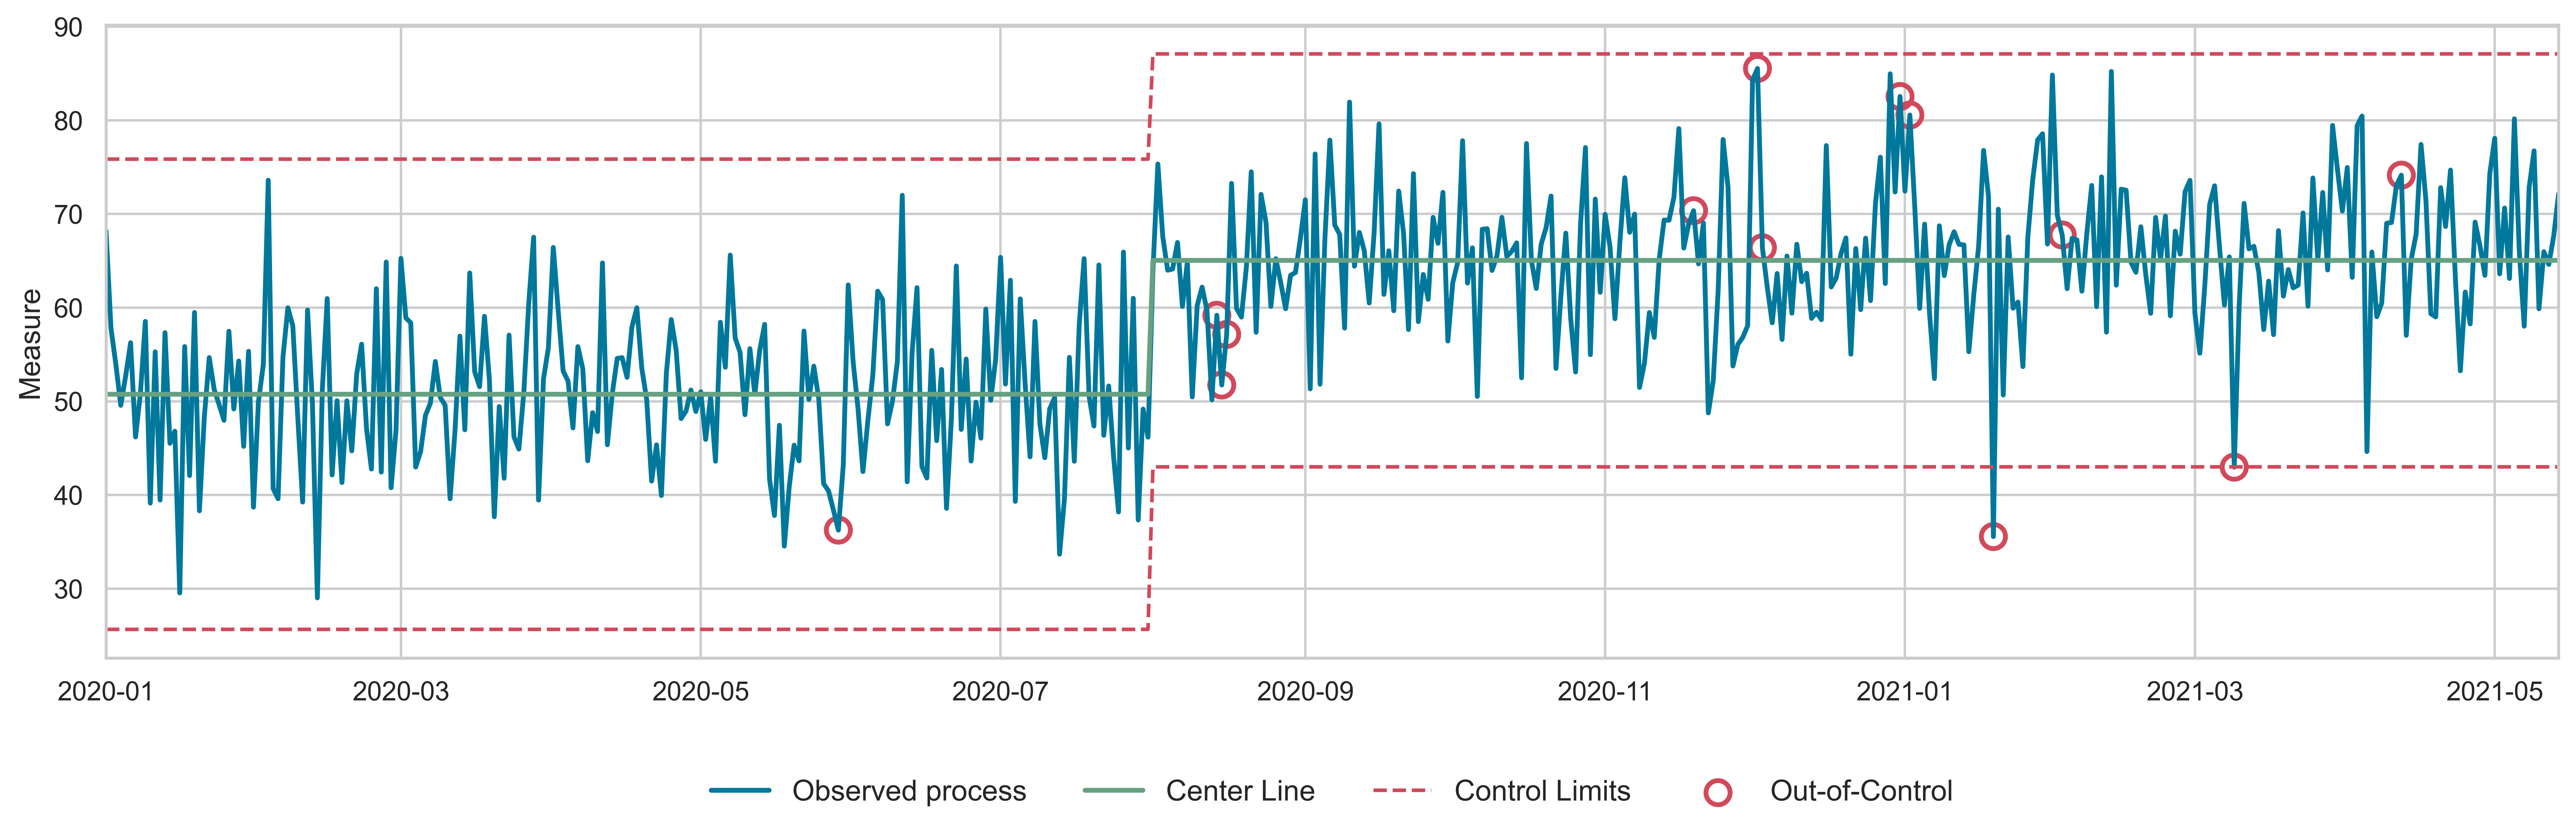

In [11]:
fig, ax = spc_plots.seaborn_chart(process_change_example_data)

## Including seasonal variation

Suppose your dataset exhibited seasonal variation (e.g., more demand on weekends).

Rather than plot two seperate SPC charts, seasonal variation can be controlled for within the same chart by passing in a custom function (returns unique value for each seasonal period) to the .add_seasonality() method of your SPC instance.

This allows for custom seasonality to be handled in a single chart. Control rules will be handled in the same way as doing seperate charts (e.g., consecutive values will be seasonally adjusted etc)

In [12]:
def is_weekend(input_date):
    """
    Custom seasonal function.
    """
    return input_date.weekday >= 5

In [13]:
process_change_example.add_seasonality(season_func=is_weekend, 
                                       min_data_req=15 # <- Min num data points per unique seasonal period required.
                                                       # If below, global average will be used
                                                       # Expanding the dataset or lowering min_data_req will allow 
                                                       # seasonal variation if there are too few data points.
                                      )

In [14]:
seasonal_controlled = process_change_example.calculate_spc(
    spc_calc_func=spc_functions.x_chart,
    rule_1=True)

seasonal_controlled.head()

CL        LCL        UCL    process  season  \
2020-01-01  50.114142  26.003179  74.225106  68.200341   False   
2020-01-02  50.114142  26.003179  74.225106  57.838531   False   
2020-01-03  50.114142  26.003179  74.225106  53.931711   False   
2020-01-04  52.366588  24.146363  80.586814  49.572630    True   
2020-01-05  52.366588  24.146363  80.586814  52.719115    True   

            Rule 1 violation  
2020-01-01                 0  
2020-01-02                 0  
2020-01-03                 0  
2020-01-04                 0  
2020-01-05                 0

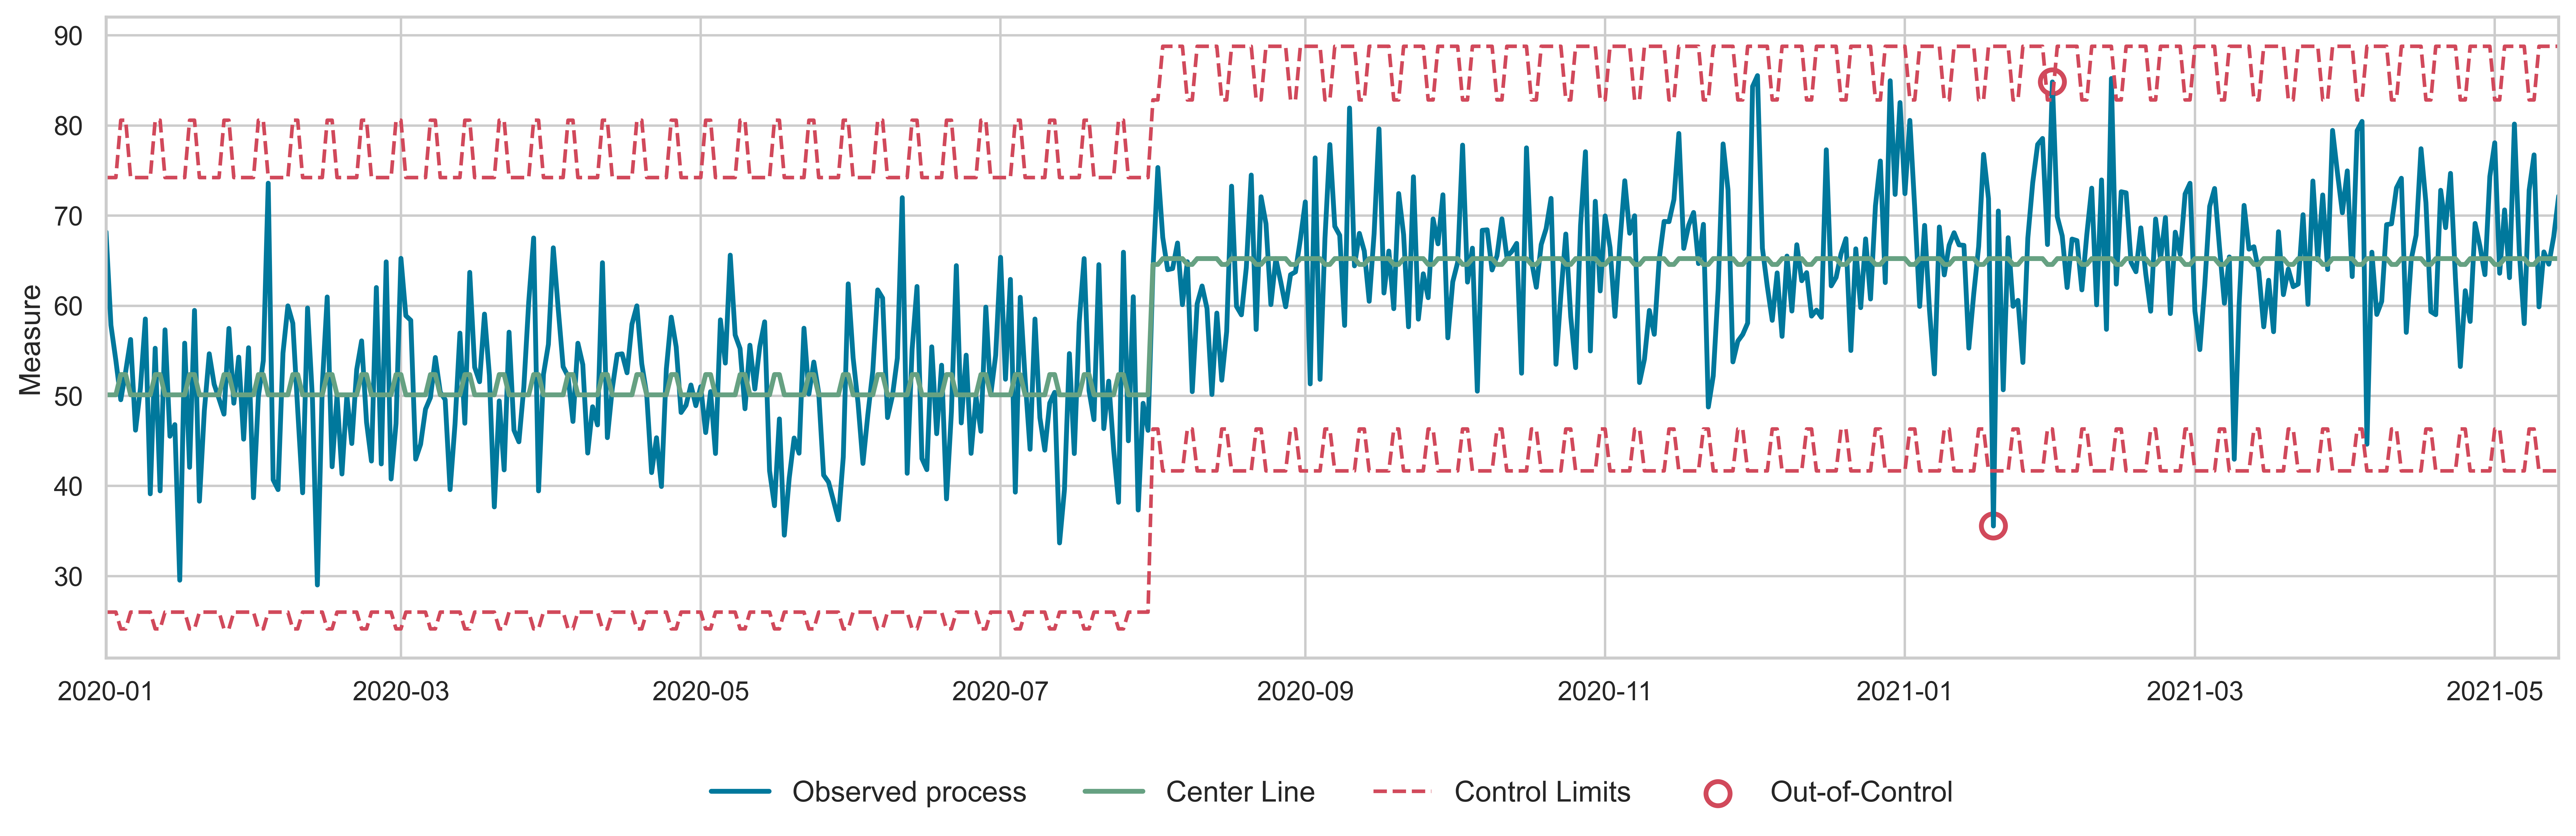

In [15]:
fig, ax = spc_plots.seaborn_chart(seasonal_controlled)

## Custom SPC functions

You are not limited to the available process control limit functions (e.g., x_chart). A custom SPC function can be passed in, as long as inputs & outputs are consistent.

In [16]:
def quantile_chart_calc(data, target_col, cl_start_dt=None, cl_end_dt=None):
    """
    All SPC functions require exactly these inputs
    """
    
    CL = data[target_col].quantile(0.5)
    LCL = data[target_col].quantile(0.025)
    UCL = data[target_col].quantile(0.975)
    
    return {'process': data[target_col], 'CL': CL, 'LCL': LCL, 'UCL': UCL}

In [17]:
custom_spc = process_change_example.calculate_spc(
    spc_calc_func=quantile_chart_calc,
    rule_1=True
)

custom_spc.head()

CL        LCL        UCL    process  season  \
2020-01-01  50.111890  35.909745  65.777552  68.200341   False   
2020-01-02  50.111890  35.909745  65.777552  57.838531   False   
2020-01-03  50.111890  35.909745  65.777552  53.931711   False   
2020-01-04  50.585541  38.379751  65.597655  49.572630    True   
2020-01-05  50.585541  38.379751  65.597655  52.719115    True   

            Rule 1 violation  
2020-01-01                 1  
2020-01-02                 0  
2020-01-03                 0  
2020-01-04                 0  
2020-01-05                 0

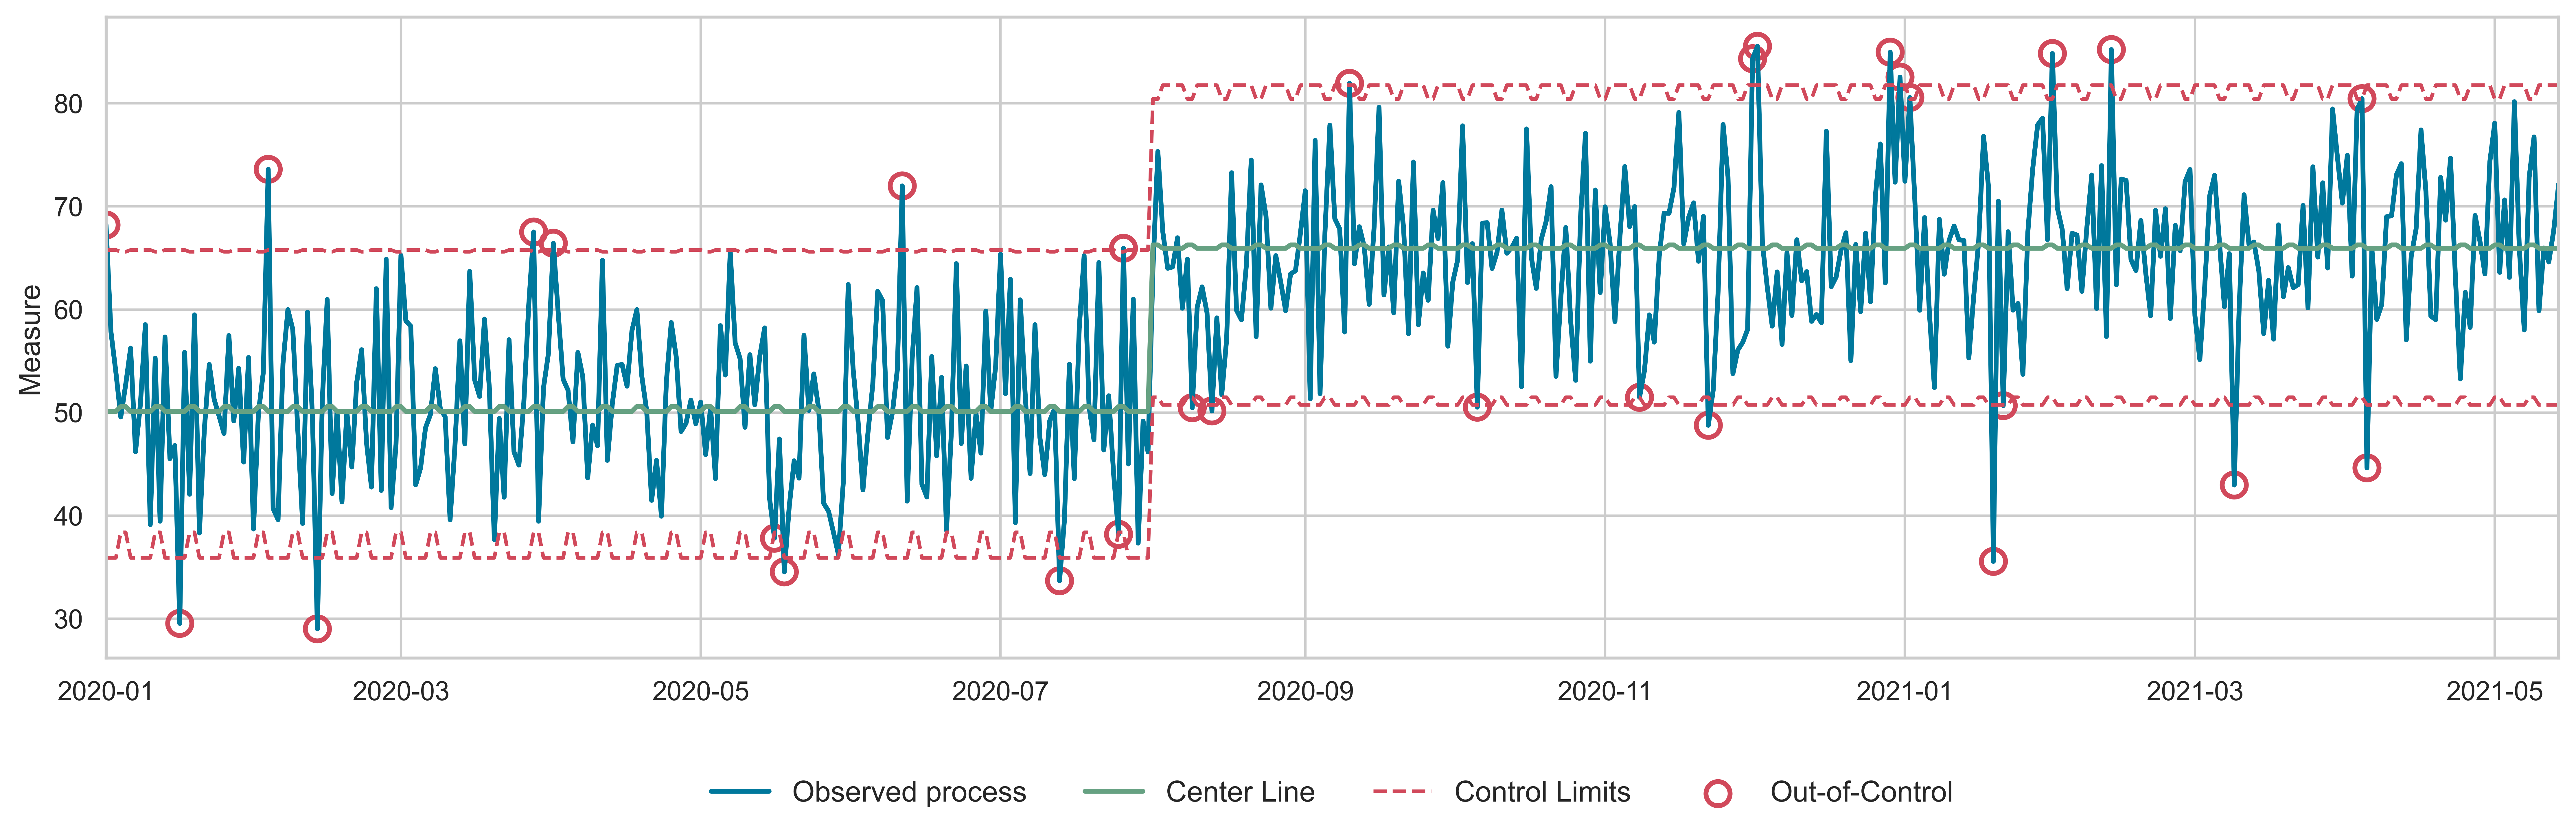

In [18]:
fig, ax = spc_plots.seaborn_chart(custom_spc)

Plotly charts are also available

In [19]:
from spyc.spc_plots import plotly_chart

In [21]:
plotly_chart(custom_spc)